In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

from collections import OrderedDict
from operator import itemgetter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline

PATH = './mlboot_dataset/'

#train_df = pd.read_csv(os.path.join(PATH,'mlboot_data.tsv'), delimiter='\t', skiprows=16028597,header=None)
#train_df.columns = ['cuid', 'cat', 'cnt1','cnt2','cnt3','data_diff']
#train_df = pd.read_csv(os.path.join(PATH, 'train_sample.csv'), nrows=400000)

In [4]:
dv = DictVectorizer(separator=':', sparse=False)

In [8]:
json.loads('{"two":3,"three":1,"two":1}')

{'three': 1, 'two': 1}

In [5]:
dv.fit_transform({'two':3, 'three':1, 'two':1})

array([[1., 1.]])

In [53]:
#train_df[:1000000].to_csv('train_sample.csv', index=False)

In [2]:
train_ans_df = pd.read_csv(os.path.join(PATH,'mlboot_train_answers.tsv'), delimiter='\t')
data = train_df.join(train_ans_df.set_index('cuid'), on='cuid', how='inner')
data['cnt1_is_not_null'] = data['cnt1'].apply(lambda x: 0 if x == "{}" else 1)
data['cnt2_is_not_null'] = data['cnt2'].apply(lambda x: 0 if x == "{}" else 1)
data['cnt3_is_not_null'] = data['cnt3'].apply(lambda x: 0 if x == "{}" else 1)

In [3]:
#Достанем кол-во счетчиков в признаке
data['count_cnt1'] = data['cnt1'].map(lambda x: len(list(json.loads(x).values())))
data['count_cnt2'] = data['cnt2'].map(lambda x: len(list(json.loads(x).values())))
data['count_cnt3'] = data['cnt3'].map(lambda x: len(list(json.loads(x).values())))
#Сумма счетчиков в признаке
data['sum_cnt1'] = data['cnt1'].map(lambda x: np.sum(list(json.loads(x).values())))
data['sum_cnt2'] = data['cnt2'].map(lambda x: np.sum(list(json.loads(x).values())))
data['sum_cnt3'] = data['cnt3'].map(lambda x: np.sum(list(json.loads(x).values())))

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2307900 entries, 0 to 3499999
Data columns (total 16 columns):
cuid                object
cat                 int64
cnt1                object
cnt2                object
cnt3                object
data_diff           int64
target              int64
cnt1_is_not_null    int64
cnt2_is_not_null    int64
cnt3_is_not_null    int64
count_cnt1          int64
count_cnt2          int64
count_cnt3          int64
sum_cnt1            float64
sum_cnt2            float64
sum_cnt3            float64
dtypes: float64(3), int64(9), object(4)
memory usage: 299.3+ MB


In [5]:
data.head()

,cuid,cat,cnt1,cnt2,cnt3,data_diff,target,cnt1_is_not_null,cnt2_is_not_null,cnt3_is_not_null,count_cnt1,count_cnt2,count_cnt3,sum_cnt1,sum_cnt2,sum_cnt3
0,d241d1f6f360965c303a30f8b471b095,1,"{""2025582"":1,""2048310"":2,""651030"":1,""1108422"":...","{""31297"":1,""28598"":1,""504988"":1,""6498"":1,""1438...",{},15,0,1,1,0,5,12,0,7.0,13.0,0.0
1,d241d1f6f360965c303a30f8b471b095,1,"{""38462"":2,""2048310"":3,""1108422"":1,""2025582"":1...","{""264772"":2,""124932"":2,""31297"":1,""19791"":1,""18...",{},16,0,1,1,0,8,30,0,14.0,40.0,0.0
2,d241d1f6f360965c303a30f8b471b095,1,"{""2025582"":4}","{""552308"":3,""186181"":2,""28598"":4,""504988"":3,""1...",{},17,0,1,1,0,1,6,0,4.0,17.0,0.0
3,d241d1f6f360965c303a30f8b471b095,1,"{""304818"":2,""815630"":1,""2048310"":4,""1108422"":1...","{""124932"":2,""31297"":1,""186181"":2,""14263"":1,""59...",{},18,0,1,1,0,8,24,0,14.0,33.0,0.0
4,d241d1f6f360965c303a30f8b471b095,1,"{""1184422"":1,""2048310"":4,""809001"":1,""2025582"":...","{""31297"":1,""19791"":1,""186181"":2,""599535"":2,""97...",{},19,0,1,1,0,12,29,0,18.0,42.0,0.0


In [6]:
def add_to_dict(d_from, d_to):
    d_from = list(d_from.items())
    for i in range(len(d_from)):
        if d_from[i][0] not in d_to.keys():
            d_to[d_from[i][0]] = d_from[i][1]
        else:
            d_to[d_from[i][0]] += d_from[i][1]
    return d_to

In [7]:
all_cat_cnt1 = dict()
for i in tqdm(data['cnt1']):
    add_to_dict(json.loads(i), all_cat_cnt1)
    
all_cat_cnt2 = dict()
for i in tqdm(data['cnt2']):
    add_to_dict(json.loads(i), all_cat_cnt2)
    
all_cat_cnt3 = dict()
for i in tqdm(data['cnt3']):
    add_to_dict(json.loads(i), all_cat_cnt3)

100%|██████████| 2307900/2307900 [00:05<00:00, 438897.35it/s]


In [8]:
print (len(list(all_cat_cnt1.keys())))
print (len(list(all_cat_cnt2.keys())))
print (len(list(all_cat_cnt3.keys())))

750289
20275
101149


In [10]:
all_cat_cnt1 = OrderedDict(sorted(all_cat_cnt1.items(), key=itemgetter(1), reverse=True))
all_cat_cnt2 = OrderedDict(sorted(all_cat_cnt2.items(), key=itemgetter(1), reverse=True))
all_cat_cnt3 = OrderedDict(sorted(all_cat_cnt3.items(), key=itemgetter(1), reverse=True))

N_top = 50
top_keys_cat1 = list(all_cat_cnt1.keys())[:N_top]
top_keys_cat2 = list(all_cat_cnt2.keys())[:N_top]
top_keys_cat3 = list(all_cat_cnt3.keys())[:N_top]

In [11]:
def get_value_by_key(d_in):
    try:
        return json.loads(d_in)[__key]
    except:
        return 0

In [12]:
for key in tqdm(top_keys_cat1):
    __key = key
    data[key+'_1'] = data['cnt1'].apply(get_value_by_key)
    
for key in tqdm(top_keys_cat2):
    __key = key
    data[key+'_2'] = data['cnt2'].apply(get_value_by_key)
    
for key in tqdm(top_keys_cat3):
    __key = key
    data[key+'_3'] = data['cnt3'].apply(get_value_by_key)

100%|██████████| 50/50 [07:24<00:00,  8.89s/it]


In [7]:
ohe = OneHotEncoder()
cat_ohe = pd.DataFrame(ohe.fit_transform(data['cat'].values.reshape(-1, 1)).toarray(), index=data.cuid)
cat_ohe = cat_ohe.groupby(['cuid']).sum()

cnt_is_null_sum = data.groupby(['cuid'])['cnt1_is_not_null','cnt2_is_not_null','cnt3_is_not_null'].sum()

new_df = pd.DataFrame()
new_df['max_data_diff'] = data.groupby(['cuid'])['data_diff'].max()
new_df['min_data_diff'] = data.groupby(['cuid'])['data_diff'].min()
new_df['delta_data_diff'] = new_df['max_data_diff'] - new_df['min_data_diff']
new_df['mean_data_diff'] = data.groupby(['cuid'])['data_diff'].mean()

#Кол-во счетчиков в признаке
new_df['max_count_cnt1'] = data.groupby(['cuid'])['count_cnt1'].max()
new_df['max_count_cnt2'] = data.groupby(['cuid'])['count_cnt2'].max()
new_df['max_count_cnt3'] = data.groupby(['cuid'])['count_cnt3'].max()
new_df['min_count_cnt1'] = data.groupby(['cuid'])['count_cnt1'].min()
new_df['min_count_cnt2'] = data.groupby(['cuid'])['count_cnt2'].min()
new_df['min_count_cnt3'] = data.groupby(['cuid'])['count_cnt3'].min()
new_df['mean_count_cnt1'] = data.groupby(['cuid'])['count_cnt1'].mean()
new_df['mean_count_cnt2'] = data.groupby(['cuid'])['count_cnt2'].mean()
new_df['mean_count_cnt3'] = data.groupby(['cuid'])['count_cnt3'].mean()

#Сумма счетчиков в признаке
new_df['max_sum_cnt1'] = data.groupby(['cuid'])['sum_cnt1'].max()
new_df['max_sum_cnt2'] = data.groupby(['cuid'])['sum_cnt2'].max()
new_df['max_sum_cnt3'] = data.groupby(['cuid'])['sum_cnt3'].max()
new_df['min_sum_cnt1'] = data.groupby(['cuid'])['sum_cnt1'].min()
new_df['min_sum_cnt2'] = data.groupby(['cuid'])['sum_cnt2'].min()
new_df['min_sum_cnt3'] = data.groupby(['cuid'])['sum_cnt3'].min()
new_df['mean_sum_cnt1'] = data.groupby(['cuid'])['sum_cnt1'].mean()
new_df['mean_sum_cnt2'] = data.groupby(['cuid'])['sum_cnt2'].mean()
new_df['mean_sum_cnt3'] = data.groupby(['cuid'])['sum_cnt3'].mean()

#Агрегация топ N счетчиков
# for i in top_keys_cat1:
#     new_df[i+'_1_sum'] = data.groupby(['cuid'])[i+'_1'].sum()
#     new_df[i+'_1_mean'] = data.groupby(['cuid'])[i+'_1'].mean()
#     new_df[i+'_1_cnt'] = data.groupby(['cuid'])[i+'_1'].apply(lambda x: np.count_nonzero(x))
# for i in top_keys_cat2:
#     new_df[i+'_2_sum'] = data.groupby(['cuid'])[i+'_2'].sum()
#     new_df[i+'_2_mean'] = data.groupby(['cuid'])[i+'_2'].mean()
# for i in top_keys_cat3:
#     new_df[i+'_3_sum'] = data.groupby(['cuid'])[i+'_3'].sum()
#     new_df[i+'_3_mean'] = data.groupby(['cuid'])[i+'_3'].mean()

#FOR TF-IDF
#data['cnt1'] = data['cnt1'].apply(lambda x: x[1:-1])
data['cnt2'] = data['cnt2'].apply(lambda x: x[1:-1])
data['cnt3'] = data['cnt3'].apply(lambda x: x[1:-1])

new_df_cnt1 = data.groupby(['cuid'])['cnt1'].sum()
new_df_cnt2 = data.groupby(['cuid'])['cnt2'].sum()
new_df_cnt3 = data.groupby(['cuid'])['cnt3'].sum()

new_df.fillna(0, inplace=True)
#Кол-во участий в опросе
new_df['count_survey'] = data.groupby(['cuid'])['cuid'].count()
target = data.groupby(['cuid'])['target'].min()

#df = pd.concat([new_df, cat_ohe, cnt_is_null_sum], axis=1, join='inner')

## TF-IDF

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = lambda doc: doc[1:-1].split(',')
tf_idf = TfidfVectorizer(tokenizer = tokenizer, max_df = 0.75, min_df = 0.01, ngram_range=(1,1))

In [86]:
tf_idf_cnt1 = tf_idf.fit_transform(new_df_cnt1)
tf_idf_cnt2 = tf_idf.fit_transform(new_df_cnt2)
tf_idf_cnt3 = tf_idf.fit_transform(new_df_cnt3)

KeyboardInterrupt: 

In [61]:
new_df.drop(axis=1, columns=['target'], inplace=True)

In [ ]:
df = hstack([new_df.astype(float), cat_ohe, cnt_is_null_sum, tf_idf_cnt1, tf_idf_cnt2, tf_idf_cnt3])

In [ ]:
df

## Посмотрим на данные

In [28]:
df[df.columns[35:40]][:10]

,1387851_1_mean,219266_1_sum,219266_1_mean,1060624_1_sum,1060624_1_mean
cuid,,,,,
d241d1f6f360965c303a30f8b471b095,0.000000,1,0.022727,0,0.000000
d2422273015f17d3b0323794d72267af,0.000000,5,0.043860,0,0.000000
d24229997aaa398a23a50327b780ee1a,0.000000,0,0.000000,0,0.000000
d24237114486ca83116b146e7cd2aa9f,0.000000,2,0.017544,0,0.000000
d242667ee758a8974dae6d1bda7bfae6,0.000000,22,0.536585,6,0.146341
d2428700a229caaa15f503deba318423,0.000000,6,0.127660,28,0.595745
d242ce710444371c60f94588274589f9,0.000000,4,0.095238,0,0.000000
d242e2a8da1f562a82eb3c41d32a52e7,0.066667,1,0.066667,0,0.000000
d24314b53531ec55a5e22e7fc712fd51,0.000000,0,0.000000,0,0.000000


In [14]:
df.head()

,max_data_diff,min_data_diff,delta_data_diff,mean_data_diff,max_count_cnt1,max_count_cnt2,max_count_cnt3,min_count_cnt1,min_count_cnt2,min_count_cnt3,...,0,1,2,3,4,5,cnt1_is_not_null,cnt2_is_not_null,cnt3_is_not_null,target
cuid,,,,,,,,,,,,,,,,,,,,,
d241d1f6f360965c303a30f8b471b095,59,15,44,37.090909,74,242,0,1,6,0,...,0.0,44.0,0.0,0.0,0.0,0.0,44,44,0,0
d2422273015f17d3b0323794d72267af,60,1,59,30.482456,30,182,13,1,3,1,...,0.0,58.0,56.0,0.0,0.0,0.0,114,114,114,0
d24229997aaa398a23a50327b780ee1a,43,42,1,42.500000,5,18,0,4,11,0,...,0.0,0.0,0.0,0.0,0.0,2.0,2,2,0,0
d24237114486ca83116b146e7cd2aa9f,60,1,59,31.017544,34,539,16,0,10,2,...,0.0,0.0,0.0,57.0,0.0,57.0,111,114,114,0
d242667ee758a8974dae6d1bda7bfae6,59,2,57,31.853659,22,66,11,1,0,0,...,0.0,0.0,0.0,0.0,0.0,41.0,41,35,8,1


In [21]:
df.describe()

,max_data_diff,min_data_diff,delta_data_diff,mean_data_diff,max_count_cnt1,max_count_cnt2,max_count_cnt3,min_count_cnt1,min_count_cnt2,min_count_cnt3,...,0,1,2,3,4,5,cnt1_is_not_null,cnt2_is_not_null,cnt3_is_not_null,target
count,76514.000000,76514.000000,76514.000000,76514.000000,76514.000000,76514.000000,76514.000000,76514.000000,76514.000000,76514.000000,...,76514.000000,76514.000000,76514.000000,76514.000000,76514.000000,76514.000000,76514.000000,76514.000000,76514.000000,76514.000000
mean,53.481716,6.856784,46.624931,30.136167,23.145137,86.990864,1.085919,1.600897,2.286967,0.015906,...,1.914512,2.030099,8.788875,1.188671,0.225736,16.015213,29.942703,28.381120,2.881630,0.051128
std,12.158758,11.538478,17.762562,8.784921,18.447898,79.885158,3.408621,1.545318,5.621687,0.201987,...,7.965497,8.233287,16.031248,6.549097,2.894051,18.456317,23.331799,22.833871,9.844736,0.220260
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.000000,1.000000,42.000000,26.820513,11.000000,33.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,10.000000,0.000000,0.000000
50%,59.000000,2.000000,56.000000,30.368421,19.000000,66.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,26.000000,25.000000,0.000000,0.000000
75%,60.000000,6.000000,59.000000,33.538462,31.000000,116.000000,1.000000,2.000000,2.000000,0.000000,...,0.000000,0.000000,10.000000,0.000000,0.000000,30.000000,44.000000,42.000000,1.000000,0.000000
max,60.000000,60.000000,59.000000,60.000000,865.000000,1469.000000,187.000000,50.000000,201.000000,13.000000,...,59.000000,59.000000,59.000000,58.000000,58.000000,59.000000,192.000000,192.000000,159.000000,1.000000


# Exploratory Data Analysis

### Распределение целевой переменной

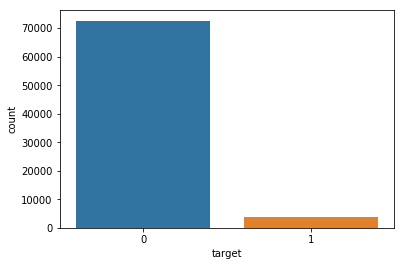

In [22]:
sns.countplot(df.target)

### Корреляция

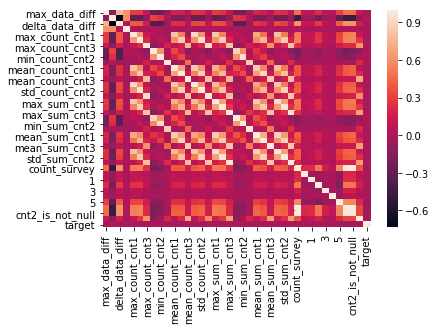

In [9]:
sns.heatmap(df.corr())

### Распределение признаков

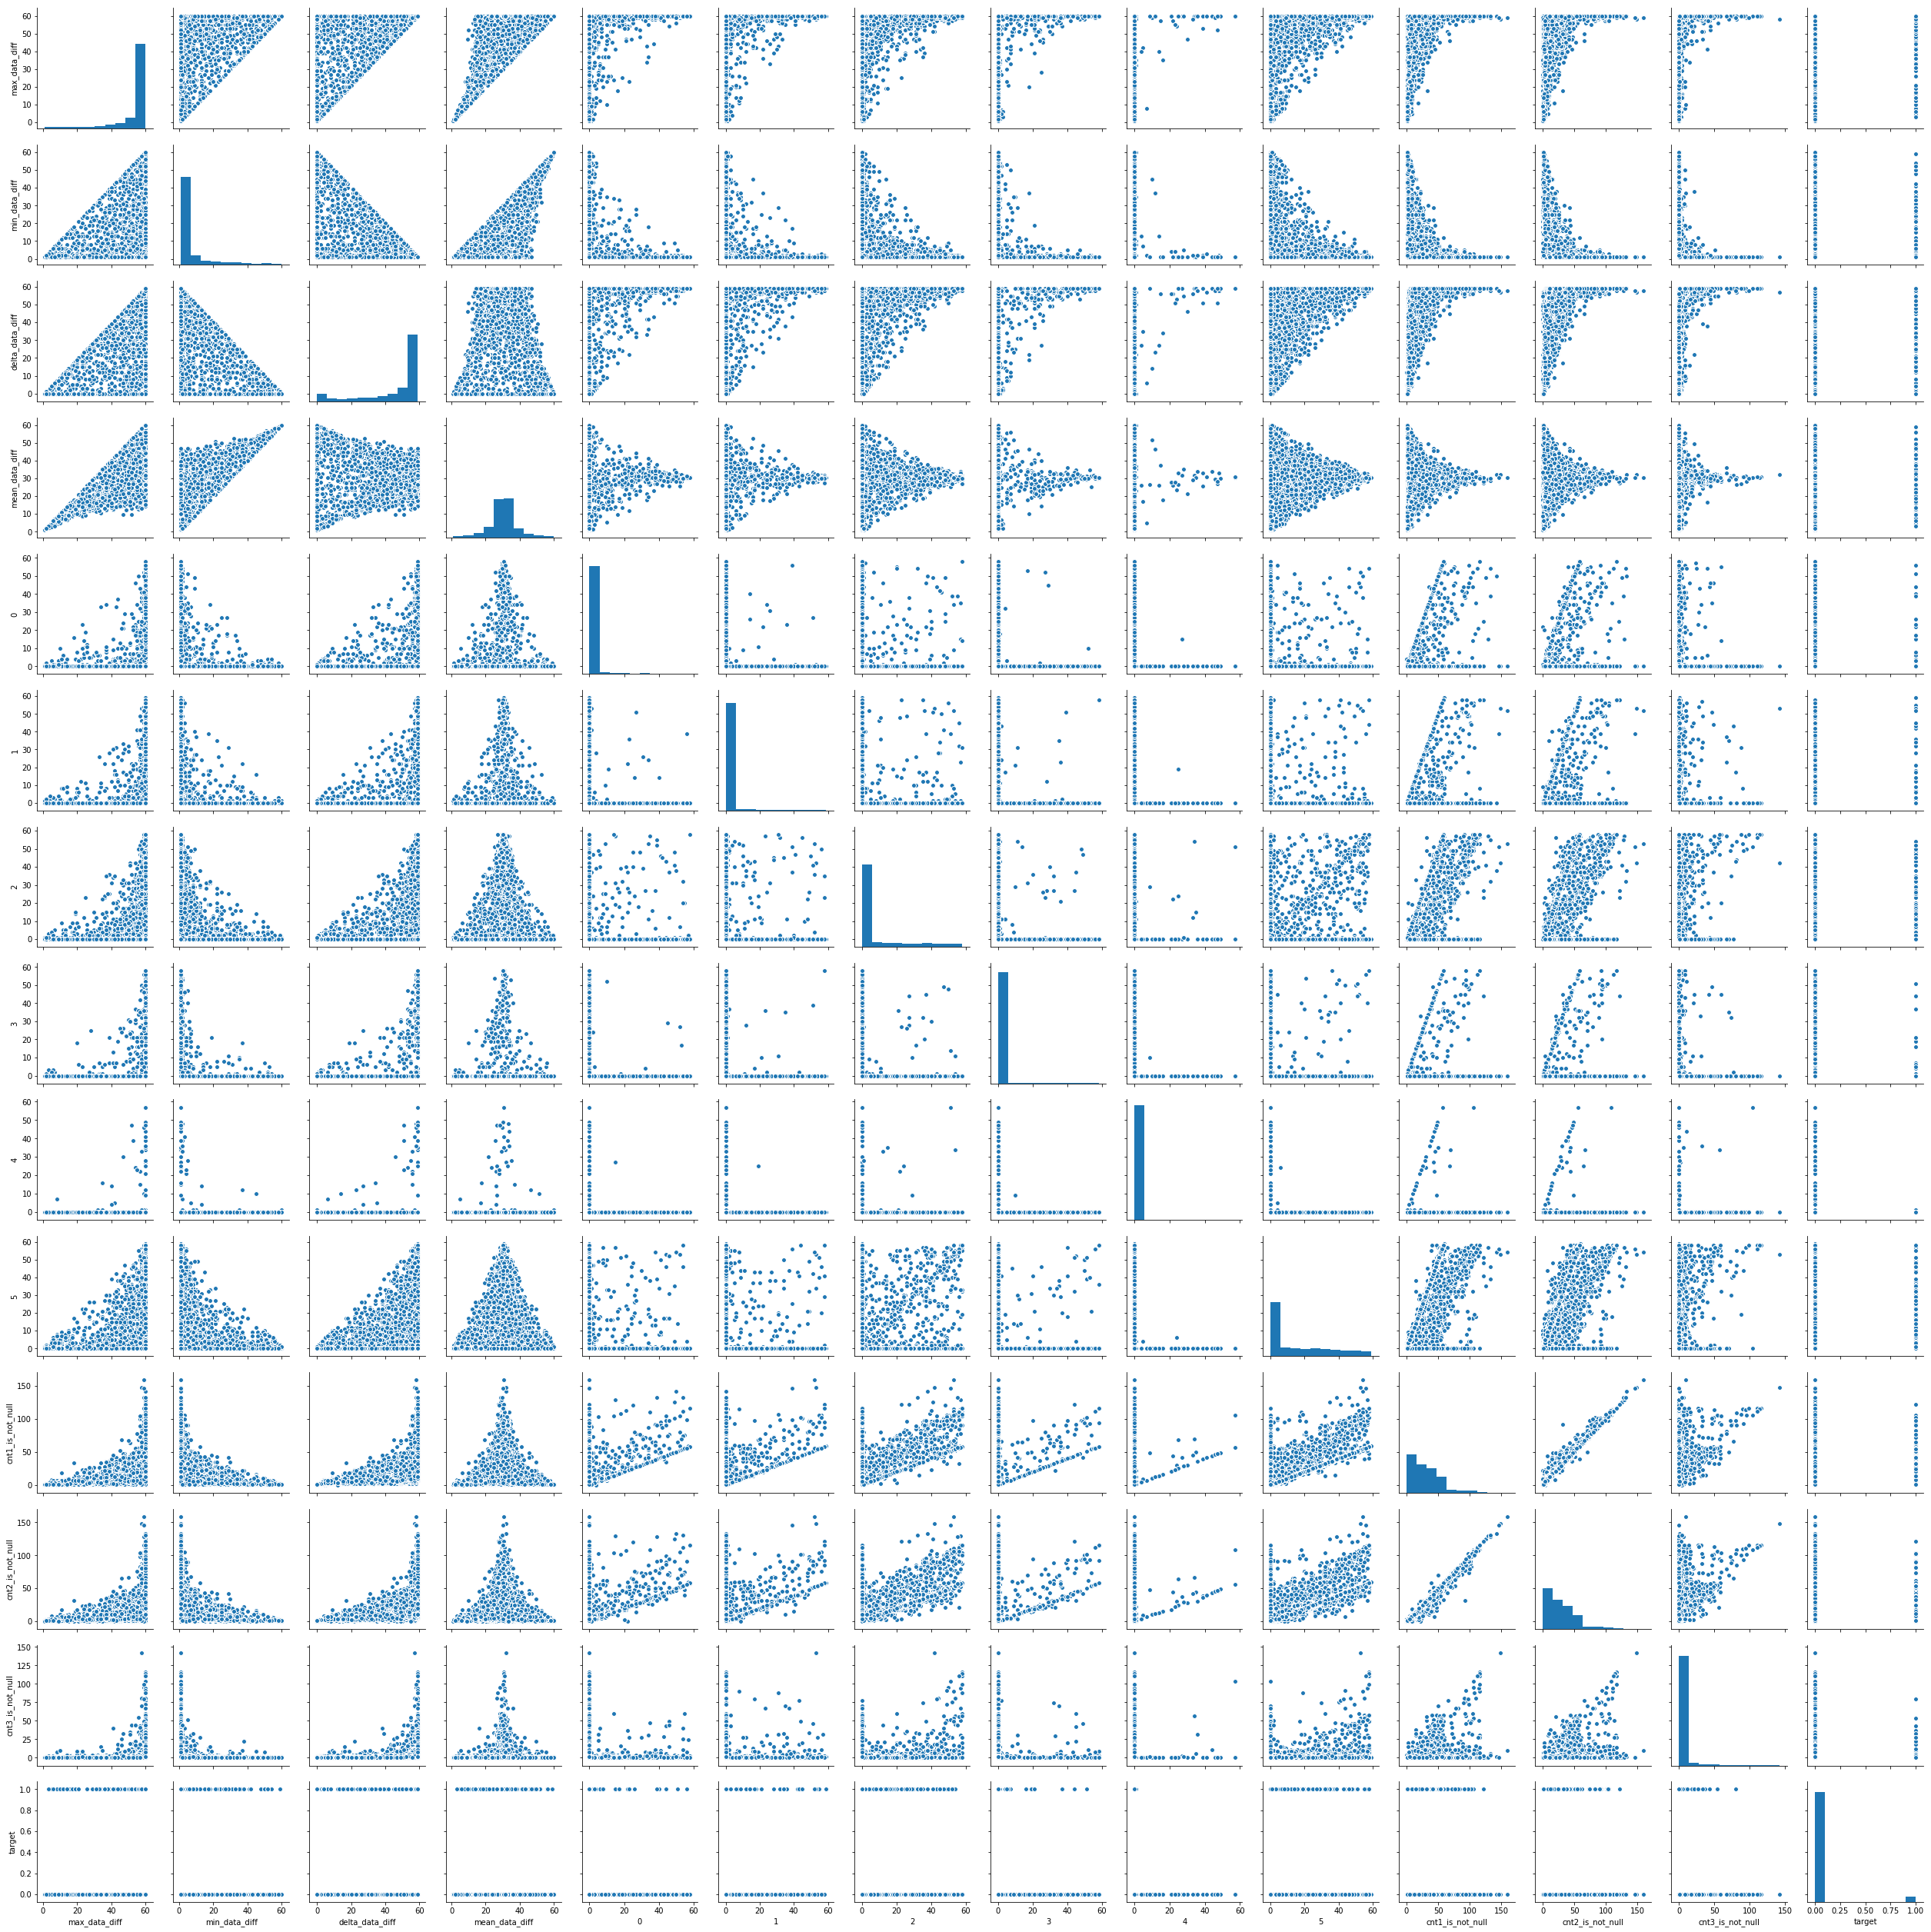

In [15]:
sns.pairplot(df)

# Models

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=17)

In [14]:
lr = LogisticRegression(penalty='l2')
cv = cross_val_score(lr,X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)
print (cv.mean(), cv.std())
lr.fit(X_train,y_train)
pred = lr.predict_proba(X_test)
print (roc_auc_score(y_test,pred[:, 1]))

0.5440022728352247 0.02742848033003436
0.5333938898477003


In [67]:
lr.coef_

array([[-0.0243403 , -0.02013828, -0.00420202,  0.0462883 , -0.00214682,
         0.00076424,  0.01666548, -0.06828493,  0.00657444,  0.11758501,
         0.01375902, -0.00500748, -0.03544154, -0.00550792,  0.00382712,
        -0.00220278,  0.00300191,  0.0002672 ,  0.00340372, -0.0138051 ,
        -0.03175344,  0.03381386,  0.00403994]])

In [13]:
rf = RandomForestClassifier()
cv = cross_val_score(rf,X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)
print (cv.mean(), cv.std())
rf.fit(X_train,y_train)
pred = rf.predict_proba(X_test)
print (roc_auc_score(y_test,pred[:, 1]))

[0.51938724 0.48846545 0.51485458 0.45942425 0.4943931 ]
0.4959396857116904


In [14]:
rf.feature_importances_

array([0.04541494, 0.04422858, 0.04886746, 0.10671989, 0.08168363,
       0.09258278, 0.0188938 , 0.03555382, 0.04364632, 0.0010261 ,
       0.10010387, 0.1017479 , 0.02909265, 0.04274453, 0.01317824,
       0.01400831, 0.02559913, 0.00758975, 0.00242136, 0.03072812,
       0.04306841, 0.05123856, 0.01986183])